Load necessary libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
figure = 0

In this assignment, we will use a neural network with one input layer (as many nodes as images pixels), one hidden layer of 50 hidden nodes the major part of time (with *ReLu* or rectified linear units as activation function), and one output layer  (as many nodes as possible image labels and *SoftMax* as activation function) with the loss function cross entropy (classification metric) with L2 regularization.  Then, the predicted class corresponds to the label with the highest predicted probability (since the sum of the output activations for a sample is 1 as consequence of using *SoftMax*).

### Exercise 1: Read in the data & initialize the parameters of the network

Load the data.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

def LoadBatch(file):
    data = unpickle(file)
    images = data[b'data'].T
    labels = data[b'labels']
    labels_one_hot = one_hot(labels) 
    return images, labels_one_hot, labels

In [3]:
images_1, labels_one_hot_1, labels_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
images_2, labels_one_hot_2, labels_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
images_3, labels_one_hot_3, labels_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
images_4, labels_one_hot_4, labels_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
images_5, labels_one_hot_5, labels_5 = LoadBatch('cifar-10-batches-py/data_batch_5')
images_test, labels_one_hot_test, labels_test = LoadBatch('cifar-10-batches-py/test_batch')
batches = unpickle('cifar-10-batches-py/batches.meta')
label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

Normalize (minus the mean and divided by standard deviation) the images by pixel (which are between 0 and 255) with respect to the training data (*data_batch_1*).

In [4]:
std_by_pixel_train = images_1.std(axis=1).reshape(images_1.shape[0], 1)
mean_by_pixel_train = images_1.mean(axis=1).reshape(images_1.shape[0], 1)
images_1 = (images_1-mean_by_pixel_train)/std_by_pixel_train
images_2 = (images_2-mean_by_pixel_train)/std_by_pixel_train
images_3 = (images_3-mean_by_pixel_train)/std_by_pixel_train
images_4 = (images_4-mean_by_pixel_train)/std_by_pixel_train
images_5 = (images_5-mean_by_pixel_train)/std_by_pixel_train
images_test = (images_test-mean_by_pixel_train)/std_by_pixel_train

Each batch contains N=10000 images (columns) of D=3072 pixels (rows) and C=10 possible labels (targets). Y is an one-hot representation matrix of the labels of the images.

$$\underset{[D \times N]}{X} \qquad \underset{[C \times N]}{Y}$$

In [5]:
images_1.shape

(3072, 10000)

In [6]:
labels_one_hot_1.shape

(10, 10000)

The images have been normalized (pixel values with zero mean and standard deviation 1).

In [7]:
type(images_1[0,0]) # float equivalent to double

numpy.float64

In [8]:
 images_1.mean(axis=1), images_1.std(axis=1)

(array([ 1.31672451e-16, -1.00430775e-16,  1.13975496e-16, ...,
        -6.08513240e-17, -8.78241924e-17,  2.62401212e-17]),
 array([1., 1., 1., ..., 1., 1., 1.]))

This is the distribution of labels by images batch.

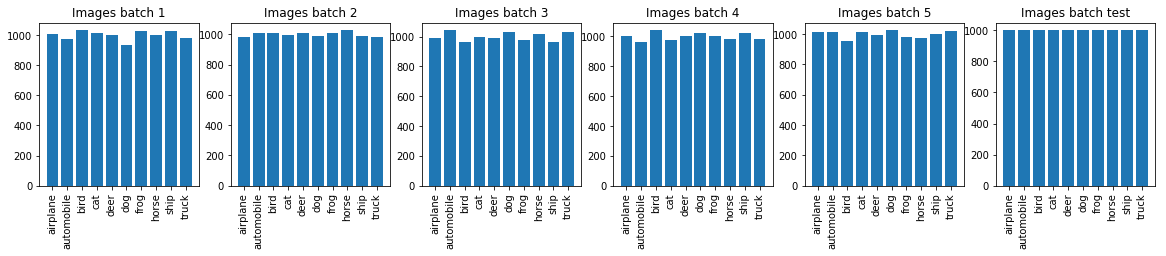

In [9]:
labels_list = [labels_1, labels_2, labels_3, labels_4, labels_5, labels_test]
titles_list = ['Images batch '+str(i) for i in [1, 2, 3, 4, 5, 'test']]
_, axes = plt.subplots(nrows=1, ncols=len(titles_list), figsize=(20,3))
for i, (labels, title) in enumerate(zip(labels_list, titles_list)):
    unique_labels = np.unique(labels)
    axes[i].bar(unique_labels, [labels.count(x) for x in unique_labels])
    axes[i].set_xticks(unique_labels)
    axes[i].set_xticklabels(labels=label_names, rotation=90)
    axes[i].set_title(title)
plt.savefig('Figures/'+str(figure)+'_Dist_Labels.png', bbox_inches="tight"); figure+=1

Initialize the weights and bias matrix.

In [10]:
def initialize_weights(input_dimension, hidden_dimension, output_dimension, xavier=True, seed=0, std=0.01):
    # Define standard deviation for random weights and bias normal distribution
    scale1 = 1/np.sqrt(input_dimension) if xavier else std
    scale2 = 1/np.sqrt(hidden_dimension) if xavier else std
    
    # Define random seed and initialize weights
    np.random.seed(seed)
    W1 = np.random.normal(size=(hidden_dimension, input_dimension), loc=0, scale=scale1)
    W2 = np.random.normal(size=(output_dimension, hidden_dimension), loc=0, scale=scale2)

    # Initialize bias with zeros
    b1 = np.zeros(shape=(hidden_dimension,1))
    b2 = np.zeros(shape=(output_dimension,1))
    
    return W1, b1, W2, b2

In [11]:
input_dimension = images_1.shape[0]
hidden_dimension = 50
output_dimension = labels_one_hot_1.shape[0]
W1, b1, W2, b2 = initialize_weights(input_dimension, hidden_dimension, output_dimension)

The shape of the weights matrix is as many rows as hidden nodes and as many columns as input nodes for the first one, and as many rows as output nodes and as many columns as hidden nodes for the second one. And for the bias only 1 column with as many rows as hidden nodes for the first one, and as much rows as output nodes for the second one.

In [12]:
W1.shape, b1.shape, W2.shape, b2.shape

((50, 3072), (50, 1), (10, 50), (10, 1))

### Exercise 2: Compute the gradients for the network parameters

Create a function to evaluate images with given weights and bias.

$$\underset{[M \times N]}{S^1} = \underset{[M \times D]}{W^1} \times \underset{[D \times N]}{X} + \underset{[M \times 1]}{b^1}$$

$$\underset{[M \times N]}{H}=ReLu\bigg(\underset{[M \times N]}{S^1}\bigg) \quad where \quad ReLu(S_{mi}^1)=max(0,S_{mi})$$

$$\underset{[C \times N]}{S} = \underset{[C \times M]}{W^2} \times \underset{[M \times N]}{H} + \underset{[C \times 1]}{b^2}$$

$$\underset{[C \times N]}{P}=SoftMax\bigg(\underset{[C \times N]}{S}\bigg) \quad where \quad SoftMax(S_{ji})=\frac{exp(S_{ji})}{\sum_{c=1}^C exp(S_{ci})}$$

In [13]:
def ReLu(S):
    H = S
    H[H<0] = 0
    return H

def softmax(S):
    exponential_S = np.exp(S)
    P = exponential_S/exponential_S.sum(axis=0)
    return P
    
def EvaluateClassifier(X, W1, b1, W2, b2):
    S1 = W1@X+b1
    H = ReLu(S1)
    S = W2@H+b2
    P = softmax(S)
    return P, H

Predicting the label of the first 100 images of batch 1, the predictions matrix shape is as many rows as possible labels and as many columns as images evaluated, and the hidden activations matrix shape is as many rows as hidden nodes and as many columns as images evaluated .

In [14]:
P, H = EvaluateClassifier(images_1[:,0:100], W1, b1, W2, b2)
P.shape, H.shape

((10, 100), (50, 100))

Define the cost function for cross entropy loss with L2 regularization term on the weights matrix.

$$J=L+\lambda(||W^1||^2+||W^2||^2)=\frac{1}{N}\sum_{i=1}^{N} -log\bigg(\underset{[1 \times C]}{Y_{:i}^T} \times \underset{[C \times 1]}{P_{:i}}\bigg) +\lambda\bigg(\sum_{m,d}^{M,D}{W_{md}^1}^{2}+\sum_{c,m}^{C,M}{W_{cm}^2}^{2}\bigg) $$

In [15]:
def ComputeCost(X, Y, W1, b1, W2, b2, lambda_):
    # Compute the predictions
    P, H = EvaluateClassifier(X, W1, b1, W2, b2)
    
    # Compute the loss function term
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    # Compute the regularization term
    loss_regularization = lambda_*((W1**2).sum()+(W2**2).sum())
    
    # Sum the total cost
    J = loss_cross/X.shape[1]+loss_regularization
    return J

Define the accuracy function given somes images with the respective labels, and some weights and bias.

In [16]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    # Compute the predictions
    P, H = EvaluateClassifier(X, W1, b1, W2, b2)
    
    # Compute the accuracy
    acc = np.mean(y==np.argmax(P, 0))
    return acc

Define the function to plot the confusion matrix given somes images with the respective labels, and some weights and bias.

In [17]:
def confusion_matrix(X, y, W1, W2, b1, b2, title=''):
    # Compute the predictions and the accuracy
    P, H = EvaluateClassifier(X, W1, b1, W2, b2)
    acc = ComputeAccuracy(X, y, W1, b1, W2, b2)
        
    # Create the confusion matrix
    prediction = np.argmax(P, 0)
    K = len(np.unique(y))
    N = len(y)
    cross = np.zeros(shape=(K,K))
    for i in range(K):
        for j in range(K):
            cross[i,j] = np.sum([True if y[x]==i and prediction[x]==j else False for x in range(N)])
    cross = pd.DataFrame(data=cross.astype(int), columns=label_names, index=label_names)
    
    # Plot the confusion matrix
    plt.figure()
    sns.heatmap(cross, cbar=False, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prediction")
    plt.ylabel("True label")
    plt.title("Accuracy="+str('%.2f' % (acc*100))+str("% ")+title)

Define the function to compute the gradients given some images and labels, the weights and the regularization parameter. We have used the following equations by data batches (and then update the weights and bias with updates equal to $-\eta_{update}$ times the following gradients).

+ Respect to weights and bias of output layer:

$$\frac{\partial \lambda||W^2||^2}{\partial W^2} = 2\lambda\underset{[C \times M]}{W^2}
\quad and \quad 
\frac{\partial L}{\partial W^2} = \frac{1}{N} \bigg(\underset{[C \times N]}{P} - \underset{[C \times N]}{Y}\bigg) \times \underset{[N \times M]}{H^T} 
$$

$$
then \quad \frac{\partial J}{\partial W^2} = \frac{\partial L}{\partial W^2} + \frac{\partial \lambda||W^2||^2}{\partial W^2}
\quad and \quad 
\frac{\partial J}{\partial b^2} = \frac{\partial L}{\partial b^2} = \frac{1}{N} \bigg(\underset{[C \times N]}{P} - \underset{[C \times N]}{Y}\bigg) \times \underset{[N \times 1]}{1} 
$$

+ Respect to weights and bias of hidden layer:

$$
\frac{\partial \lambda||W^1||^2}{\partial W^1} = 2\lambda\underset{[M \times D]}{W^1}
\quad and \quad
\frac{\partial L}{\partial W^1} = \frac{1}{N} \underset{[M \times N]}{G} \times \underset{[N \times D]}{X^T}
$$

$$
with \quad 
\underset{[M \times N]}{G} = \bigg( \bigg( \underset{[M \times C]}{{W^2}^T} \times \bigg(\underset{[C \times N]}{P} - \underset{[C \times N]}{Y}\bigg) \bigg)* \bigg(Ind(\underset{[M \times N]}{H}>0)\bigg) \bigg)
$$

$$
then \quad \frac{\partial J}{\partial W^1} = \frac{\partial L}{\partial W^1} + \frac{\partial \lambda||W^1||^2}{\partial W^1}
\quad and \quad
\frac{\partial L}{\partial b^1} = \frac{1}{N} \underset{[M \times N]}{G} \times \underset{[N \times 1]}{1}
$$

In [18]:
def ComputeGradients(X, Y, P, H, W1, W2, lambda_):
    n = X.shape[1]
    C = Y.shape[0]
    M = H.shape[0]
    G = P-Y
    grad_W2 = (G@H.T)/n+2*lambda_*W2
    grad_b2 = (G@np.ones(shape=(n,1))/n).reshape(C, 1)
    G = W2.T@G
    G = G*(H>0)
    grad_W1 = (G@X.T)/n+2*lambda_*W1
    grad_b1 = (G@np.ones(shape=(n,1))/n).reshape(M, 1)
    return grad_W2, grad_b2, grad_W1, grad_b1

#### Reformulating ComputeGradsNum.m in Python (numerically computed gradient with finite difference method)

In [19]:
def ComputeGradsNum(X, Y, W1, b1, W2, b2, lambda_, h=0.00001):
    grad_W2 = np.zeros(shape=W2.shape)
    grad_b2 = np.zeros(shape=b2.shape)
    grad_W1 = np.zeros(shape=W1.shape)
    grad_b1 = np.zeros(shape=b1.shape)   
    c = ComputeCost(X, Y, W1, b1, W2, b2, lambda_)
    
    for i in range(b1.shape[0]):
        b1_try = b1.copy()
        b1_try[i,0] = b1_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1_try, W2, b2, lambda_)
        grad_b1[i,0] = (c2-c)/h
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1_try = W1.copy()
            W1_try[i,j] = W1_try[i,j]+h
            c2 = ComputeCost(X, Y, W1_try, b1, W2, b2, lambda_)
            grad_W1[i,j] = (c2-c)/h
    
    for i in range(b2.shape[0]):
        b2_try = b2.copy()
        b2_try[i,0] = b2_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1, W2, b2_try, lambda_)
        grad_b2[i,0] = (c2-c)/h
    
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = W2.copy()
            W2_try[i,j] = W2_try[i,j]+h
            c2 = ComputeCost(X, Y, W1, b1, W2_try, b2, lambda_)
            grad_W2[i,j] = (c2-c)/h
    
    return grad_W2, grad_b2, grad_W1, grad_b1

#### Compare the numerically and analytically computed gradient

We want to check that the gradients computed in the gradients function correspond to the correct gradients. To do this,
we compare the gradient obtained by the network with the gradient computed with the finite difference method.

- 20 first dimensions of the first image of data batch 1 without regularization:

In [20]:
X = images_1[0:20,[0]]
Y = labels_one_hot_1[:,[0]]
lambda_ = 0

# Compute the gradients analytically
P, H = EvaluateClassifier(X, W1[:,0:20], b1, W2, b2)
grad_W2_a, grad_b2_a, grad_W1_a, grad_b1_a = ComputeGradients(X, Y, P, H, W1[:,0:20], W2, lambda_)

# Compute the gradients numerically
grad_W2_n, grad_b2_n, grad_W1_n, grad_b1_n = ComputeGradsNum(X, Y, W1[:,0:20], b1, W2, b2, lambda_,
                                                             h=0.000001)

# Absolute error between numerically and analytically computed gradient
grad_W1_abs_diff = np.abs(grad_W1_n-grad_W1_a)
grad_b1_abs_diff = np.abs(grad_b1_n-grad_b1_a)
grad_W2_abs_diff = np.abs(grad_W2_n-grad_W2_a)
grad_b2_abs_diff = np.abs(grad_b2_n-grad_b2_a)
print('For weights 1: '+str(np.mean(grad_W1_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias 1: '+str(np.mean(grad_b1_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights 2: '+str(np.mean(grad_W2_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias 2: '+str(np.mean(grad_b2_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights 1 the maximum absolute error is '+str((grad_W1_abs_diff).max()))
print('For bias 1 the maximum absolute error is '+str((grad_b1_abs_diff).max()))
print('For weights 2 the maximum absolute error is '+str((grad_W2_abs_diff).max()))
print('For bias 2 the maximum absolute error is '+str((grad_b2_abs_diff).max()), "\n")

# Relative error between numerically and analytically computed gradient
grad_W1_abs_sum = np.maximum(np.abs(grad_W1_n)+np.abs(grad_W1_a), 0.00000001)
grad_b1_abs_sum = np.maximum(np.abs(grad_b1_n)+np.abs(grad_b1_a), 0.00000001)
grad_W2_abs_sum = np.maximum(np.abs(grad_W2_n)+np.abs(grad_W2_a), 0.00000001)
grad_b2_abs_sum = np.maximum(np.abs(grad_b2_n)+np.abs(grad_b2_a), 0.00000001)
print('For weights 1: '+str(np.mean(grad_W1_abs_diff/grad_W1_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias 1: '+str(np.mean(grad_b1_abs_diff/grad_b1_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights 2: '+str(np.mean(grad_W2_abs_diff/grad_W2_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias 2: '+str(np.mean(grad_b2_abs_diff/grad_b2_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights 1 the maximum relative error is '+str((grad_W1_abs_diff/grad_W1_abs_sum).max()))
print('For bias 1 the maximum relative error is '+str((grad_b1_abs_diff/grad_b1_abs_sum).max()))
print('For weights 2 the maximum relative error is '+str((grad_W2_abs_diff/grad_W2_abs_sum).max()))
print('For bias 2 the maximum relative error is '+str((grad_b2_abs_diff/grad_b2_abs_sum).max()))

For weights 1: 100.0% of absolute errors below 1e-6
For bias 1: 100.0% of absolute errors below 1e-6
For weights 2: 100.0% of absolute errors below 1e-6
For bias 2: 100.0% of absolute errors below 1e-6
For weights 1 the maximum absolute error is 2.3969810553081672e-08
For bias 1 the maximum absolute error is 1.6308586939239866e-08
For weights 2 the maximum absolute error is 6.342174235871717e-10
For bias 2 the maximum absolute error is 4.650366279557172e-08 

For weights 1: 99.0% of relative errors below 1e-6
For bias 1: 100.0% of relative errors below 1e-6
For weights 2: 98.0% of relative errors below 1e-6
For bias 2: 100.0% of relative errors below 1e-6
For weights 1 the maximum relative error is 1.750535834857242e-05
For bias 1 the maximum relative error is 7.80172589352941e-07
For weights 2 the maximum relative error is 4.666738108631864e-06
For bias 2 the maximum relative error is 2.2656140932957103e-07


- All dimensions of the first 5 images of batch 1 with regularization:

In [21]:
X = images_1[:,0:5]
Y = labels_one_hot_1[:,0:5]
lambda_ = 0.01

# Compute the gradients analytically
P, H = EvaluateClassifier(X, W1, b1, W2, b2)
grad_W2_a, grad_b2_a, grad_W1_a, grad_b1_a = ComputeGradients(X, Y, P, H, W1, W2, lambda_)

# Compute the gradients numerically
grad_W2_n, grad_b2_n, grad_W1_n, grad_b1_n = ComputeGradsNum(X, Y, W1, b1, W2, b2, lambda_, h=0.000001)

# Absolute error between numerically and analytically computed gradient.
grad_W1_abs_diff = np.abs(grad_W1_n-grad_W1_a)
grad_b1_abs_diff = np.abs(grad_b1_n-grad_b1_a)
grad_W2_abs_diff = np.abs(grad_W2_n-grad_W2_a)
grad_b2_abs_diff = np.abs(grad_b2_n-grad_b2_a)
print('For weights 1: '+str(np.mean(grad_W1_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias 2: '+str(np.mean(grad_b1_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights 2: '+str(np.mean(grad_W2_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias 2: '+str(np.mean(grad_b2_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights 1 the maximum absolute error is '+str((grad_W1_abs_diff).max()))
print('For bias 1 the maximum absolute error is '+str((grad_b1_abs_diff).max()))
print('For weights 2 the maximum absolute error is '+str((grad_W2_abs_diff).max()))
print('For bias 2 the maximum absolute error is '+str((grad_b2_abs_diff).max()), "\n")

# Relative error between numerically and analytically computed gradient.
grad_W1_abs_sum = np.maximum(np.abs(grad_W1_n)+np.abs(grad_W1_a), 0.00000001)
grad_b1_abs_sum = np.maximum(np.abs(grad_b1_n)+np.abs(grad_b1_a), 0.00000001)
grad_W2_abs_sum = np.maximum(np.abs(grad_W2_n)+np.abs(grad_W2_a), 0.00000001)
grad_b2_abs_sum = np.maximum(np.abs(grad_b2_n)+np.abs(grad_b2_a), 0.00000001)
print('For weights 1: '+str(np.mean(grad_W1_abs_diff/grad_W1_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias 1: '+str(np.mean(grad_b1_abs_diff/grad_b1_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights 2: '+str(np.mean(grad_W2_abs_diff/grad_W2_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias 2: '+str(np.mean(grad_b2_abs_diff/grad_b2_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights 1 the maximum relative error is '+str((grad_W1_abs_diff/grad_W1_abs_sum).max()))
print('For bias 1 the maximum relative error is '+str((grad_b1_abs_diff/grad_b1_abs_sum).max()))
print('For weights 2 the maximum relative error is '+str((grad_W2_abs_diff/grad_W2_abs_sum).max()))
print('For bias 2 the maximum relative error is '+str((grad_b2_abs_diff/grad_b2_abs_sum).max()))

For weights 1: 100.0% of absolute errors below 1e-6
For bias 2: 100.0% of absolute errors below 1e-6
For weights 2: 100.0% of absolute errors below 1e-6
For bias 2: 100.0% of absolute errors below 1e-6
For weights 1 the maximum absolute error is 5.068122367613004e-08
For bias 1 the maximum absolute error is 1.3667746365242373e-08
For weights 2 the maximum absolute error is 1.7868939541920703e-07
For bias 2 the maximum absolute error is 7.75657366335579e-08 

For weights 1: 80.54166666666667% of relative errors below 1e-6
For bias 1: 96.0% of relative errors below 1e-6
For weights 2: 86.0% of relative errors below 1e-6
For bias 2: 90.0% of relative errors below 1e-6
For weights 1 the maximum relative error is 0.05691830381198722
For bias 1 the maximum relative error is 9.024710090829038e-06
For weights 2 the maximum relative error is 3.3871816160054506e-05
For bias 2 the maximum relative error is 2.2522124179982922e-05


## Exercise 3: Train your network with cyclical learning rates

Define the function for the mini batch gradient descent with cyclical learning rates.

$$W^k_{t+1} = W^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial W^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial W^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial W^k}$$

$$b^k_{t+1} = b^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial b^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial b^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial b^k}$$

In [22]:
def MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2, X_val=None, Y_val=None, y_val=None, lambda_= 0, 
                return_etas=False, return_weights_by_cycles=False, dropout=None, max_updates=None):
    n = X.shape[1]
    eta_min = GDparams['eta_min']
    eta_max = GDparams['eta_max']
    eta_range = eta_max-eta_min
    step_size = GDparams['step_size']
    n_batch = GDparams['n_batch']
    cycles = GDparams['cycles']
    
    # Create a copy of weights and bias to update
    W1, W2, b1, b2 = W1.copy(), W2.copy(), b1.copy(), b2.copy()
    
    # Create a dictionary to store the performance metrics
    metrics = {'updates':[-1], 
               'loss_train':[ComputeCost(X, Y, W1, b1, W2, b2, lambda_)], 
               'acc_train':[ComputeAccuracy(X, y, W1, b1, W2, b2)]}
    if X_val is not None:
        metrics['loss_val'] = [ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambda_)]
        metrics['acc_val'] = [ComputeAccuracy(X_val, y_val, W1, b1, W2, b2)]
    
    # Create a dictionary to save the mask of each sample by batches (if required)
    if dropout is not None:
        masks_drouput_by_batch = {}
    
    # Define all the batches
    data_batches = {}
    max_batch_index = n//n_batch-1
    for j in range(max_batch_index+1):            
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
        # Create a boolean mask (hidden activations to switch off) for each sample in the batch
        if dropout is not None:
            hidden_dimension = W1.shape[0]
            np.random.seed(j)
            masks_drouput_by_batch[j] = np.random.rand(hidden_dimension, n_batch) < dropout
    
    # Define a dictionary to save the weights by cycles (if required)
    if return_weights_by_cycles:
        weights_by_cycles = {}
    
    # Define lists to save the etas and update steps (if required)
    if return_etas:
        etas = []
        update_step = []
    
    # Iterate cycles
    batch_index = 0
    for cycle in range(cycles):
        
        # Break cycles loop if max updates is achieved
        if max_updates is not None and max_updates == "Done":
            break
        
        # Iterate update steps
        for t in range(2*cycle*step_size, 2*(cycle+1)*step_size):
            
            # Break updates loop if max updates is achieved
            if max_updates is not None:
                if (t+1)>max_updates:
                    max_updates = "Done"
                    break
            
            # Update the eta:
            #  - first half cycle = increasing eta
            if t>= 2*cycle*step_size and t<(2*cycle+1)*step_size:
                eta = eta_min+(t-2*cycle*step_size)/step_size*eta_range
            #  - second half cycle = decreasing eta
            elif t>=(2*cycle+1)*step_size and t<2*(cycle+1)*step_size:
                eta = eta_max-(t-(2*cycle+1)*step_size)/step_size*eta_range
            
            # Save the etas and update steps (if required)
            if return_etas:
                etas.append(eta)
                update_step.append(t+1)

            # Compute gradients and update weights and bias for this update/batch
            X_batch, Y_batch, y_batch = data_batches[batch_index]
            P_batch, H_batch = EvaluateClassifier(X_batch, W1, b1, W2, b2)
            if dropout is not None:
                H_batch = H_batch*masks_drouput_by_batch[batch_index]
            grad_W2, grad_b2, grad_W1, grad_b1 = ComputeGradients(X_batch, Y_batch, P_batch, H_batch,
                                                                  W1, W2, lambda_)
            W1 += -eta*grad_W1
            b1 += -eta*grad_b1
            W2 += -eta*grad_W2
            b2 += -eta*grad_b2
            
            # Update the batch index for next update step
            batch_index += 1
            if batch_index>max_batch_index:
                batch_index = 0
                
                # Save the performance metrics of the epoch (after all batches computed)
                metrics['updates'].append(t+1)
                metrics['acc_train'].append(ComputeAccuracy(X, y, W1, b1, W2, b2))
                metrics['loss_train'].append(ComputeCost(X, Y, W1, b1, W2, b2, lambda_))
                if X_val is not None:
                    metrics['acc_val'].append(ComputeAccuracy(X_val, y_val, W1, b1, W2, b2))
                    metrics['loss_val'].append(ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambda_))
                
                # Show monitoring message of training
                message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['loss_train'][-1])+ \
                          " and accuracy="+str(metrics['acc_train'][-1])+" (training set) \r"
                sys.stdout.write(message)
            
        # Save the weights by cycles (if required)
        if return_weights_by_cycles:
            weights_by_cycles[cycle] = (W1.copy(), b1.copy(), W2.copy(), b2.copy())
        
    if return_etas and return_weights_by_cycles:
        return W1, b1, W2, b2, metrics, etas, update_step, weights_by_cycles
    elif return_etas:
        return W1, b1, W2, b2, metrics, etas, update_step
    elif return_weights_by_cycles:
        return W1, b1, W2, b2, metrics, weights_by_cycles
    else:
        return W1, b1, W2, b2, metrics

#### Visualization of the learning curve

In [23]:
def plot_learning_curve(metrics, title='', step_size=None, cycles=None):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.suptitle('Learning curves '+title)
    
    # Iterate the performance metrics
    for metric, ax in zip(['loss', 'acc'], axes.flatten()):
        
        # Find the optimal metric value and the corresponding epoch for training set
        optimal_epoch_train = np.argmin(metrics[metric+'_train']) if metric=='loss' else \
                              np.argmax(metrics[metric+'_train'])
        optimal_train = np.round(metrics[metric+'_train'][optimal_epoch_train], 4)
        
        # Plot vertical red lines each step size (if required)
        if step_size is not None and cycles is not None:
            for x in np.arange(step_size, 2*step_size*cycles+1, step_size):
                label = "Step size" if x==step_size else ""
                ax.axvline(x, c="red", linestyle="--", linewidth=0.5, label=label)
        
        # Plot the learning curve of training set
        label = 'Train: '+str(optimal_train)+' at update '+str(metrics['updates'][optimal_epoch_train])+ \
                ' or epoch '+ str(optimal_epoch_train)
        ax.plot(metrics['updates'], metrics[metric+'_train'], label=label)
        
        # If validation set...
        if len(metrics)>3:
        
            # Find the optimal metric value and the corresponding epoch for training set
            optimal_epoch_val = np.argmin(metrics[metric+'_val']) if metric=='loss' else \
                                np.argmax(metrics[metric+'_val'])
            optimal_val = np.round(metrics[metric+'_val'][optimal_epoch_val], 4)
            
            # Plot the learning curve of validation set
            label = 'Validation: '+str(optimal_val)+' at update '+ \
                    str(metrics['updates'][optimal_epoch_val])+' or epoch '+str(optimal_epoch_val)
            ax.plot(metrics['updates'], metrics[metric+'_val'], label=label)
        
        # Add axis, legend and grid
        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax.legend()
        ax.grid(True)

#### Sanity check

Once I am convinced that my analytic gradient computations are correct then I can move forward with the following sanity check. I will train my network on a small amount of the training data (say 100 examples) with regularization turned off ($\lambda$=0) and check if I can overfit to the training data and get a very low loss on the training data after training for a suffcient number of epochs (~200) and with a reasonable $\eta$. Being able to achieve this indicates that my gradient computations and mini-batch gradient descent algorithm are okay.

*Note*: 200 epochs = 2 cycles · 2 · 500 step_size / (100 images / 10 batch_size)

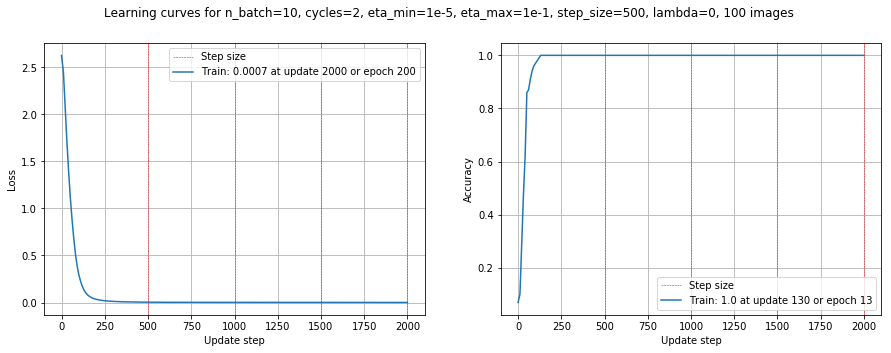

In [24]:
# Define the network parameters
X, Y, y = images_1[:,0:100], labels_one_hot_1[:,0:100], labels_1[0:100]
lambda_check = 0
GDparams_check = {'n_batch':10, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':500, 'cycles':2}

# Train the network
W1_check, b1_check, W2_check, b2_check, metrics_check, etas_check, update_step_check = \
    MiniBatchGD(X, Y, y, GDparams_check, W1, W2, b1, b2, lambda_=lambda_check, return_etas=True)

# Plot the learning curve
title_check = 'for n_batch=10, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=500, lambda=0, 100 images'
plot_learning_curve(metrics_check, title=title_check, step_size=GDparams_check['step_size'],
                    cycles=GDparams_check['cycles'])
plt.savefig('Figures/'+str(figure)+'_Sanity_Check.png', bbox_inches="tight"); figure+=1

We can plot the learning rate cycle.

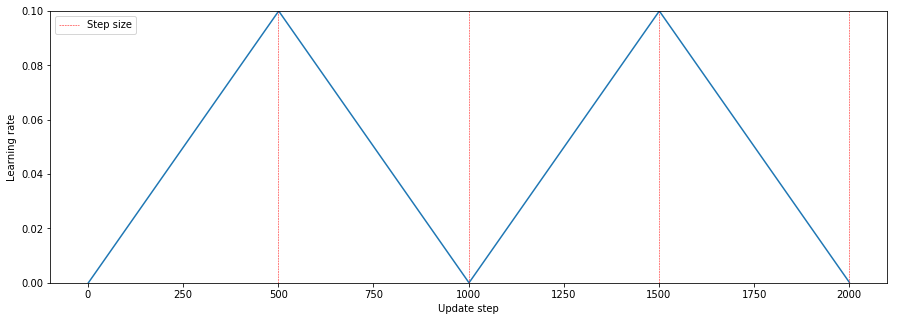

In [25]:
plt.figure(figsize=(15,5))
plt.plot(update_step_check, etas_check)
for x in np.arange(GDparams_check['step_size'], 2*GDparams_check['step_size']*GDparams_check['cycles']+1,
                   GDparams_check['step_size']):
    label = "Step size" if x==GDparams_check['step_size'] else ""
    plt.axvline(x, c="red", linestyle="--", linewidth=0.5, label=label)
plt.ylim(GDparams_check['eta_min'], GDparams_check['eta_max'])
plt.xlabel("Update step")
plt.ylabel("Learning rate")
plt.legend()
plt.savefig('Figures/'+str(figure)+'_Cyclic_LR.png', bbox_inches="tight"); figure+=1

#### Example figure 3

Using data in the file *data_batch_1* for training and the file *data_batch_2* for validation.

- Case figure 3: lambda=0.01, eta_min=1e-5, eta_max=1e-1, cycles=1, step_size=500, n_batch=100

*Note*: It is equivalent to 10 epochs = 1 cycles · 2 · 500 / (10.000/100)

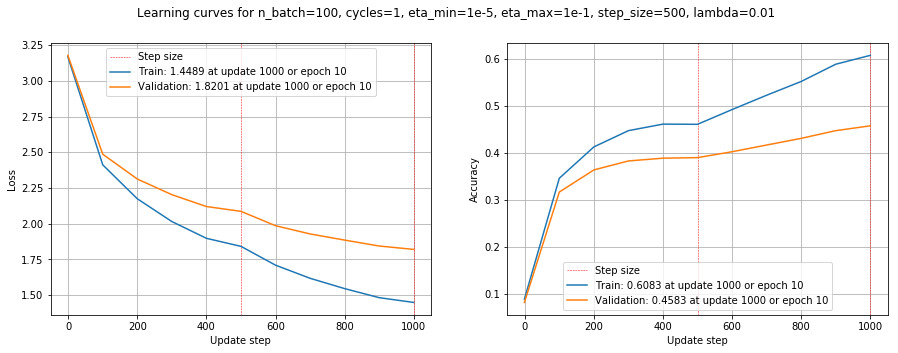

In [26]:
# Define the network parameters
lambda_f3 = 0.01
GDparams_f3 = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':500, 'cycles':1}

# Train the network
W1_f3, b1_f3, W2_f3, b2_f3, metrics_f3 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_f3,
                                                     W1, W2, b1, b2, lambda_=lambda_f3, X_val=images_2,
                                                     Y_val=labels_one_hot_2, y_val=labels_2)

# Plot the learning curve
title_f3 = 'for n_batch=100, cycles=1, eta_min=1e-5, eta_max=1e-1, step_size=500, lambda=0.01'
plot_learning_curve(metrics_f3, title=title_f3, step_size=GDparams_f3['step_size'],
                    cycles=GDparams_f3['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Fig3.png', bbox_inches="tight"); figure+=1

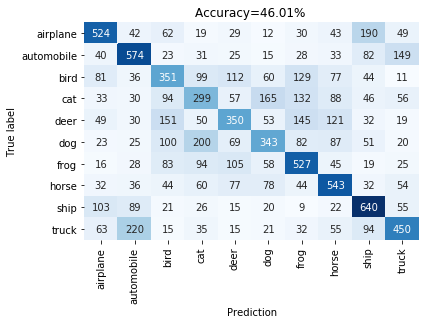

In [27]:
confusion_matrix(images_test, labels_test, W1_f3, W2_f3, b1_f3, b2_f3, title='')
plt.savefig('Figures/'+str(figure)+'_Confusion_Fig3.png', bbox_inches="tight"); figure+=1

## Exercise 4: Train your network for real

### Example figure 4

Using data in the file *data_batch_1* for training and the file *data_batch_2* for validation.

- Case figure 4: lambda=0.01, eta_min=1e-5, eta_max=1e-1, cycles=3, step_size=800, n_batch=100

*Note*: Then it is equivalent to 3 cycles · 2 · 800 / (10.000/100) = 48 epochs

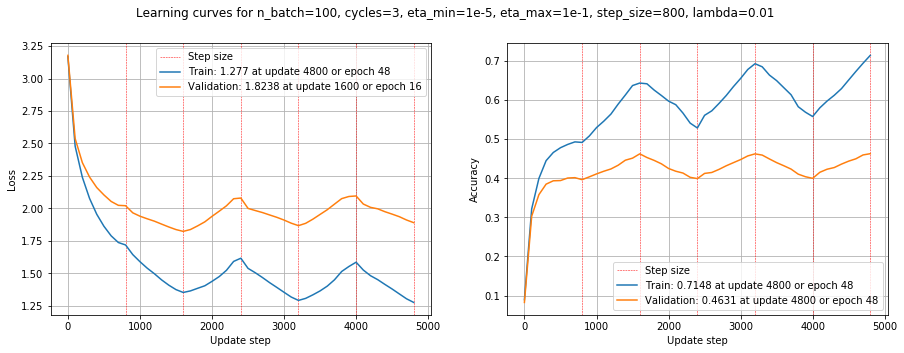

In [28]:
# Define the network parameters
lambda_f4 = 0.01
GDparams_f4 = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':800, 'cycles':3}

# Train the network
W1_f4, b1_f4, W2_f4, b2_f4, metrics_f4 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_f4, 
                                                     W1, W2, b1, b2, lambda_=lambda_f4, X_val=images_2, 
                                                     Y_val=labels_one_hot_2, y_val=labels_2)

# Plot the learning curve
title_f4 = 'for n_batch=100, cycles=3, eta_min=1e-5, eta_max=1e-1, step_size=800, lambda=0.01'
plot_learning_curve(metrics_f4, title=title_f4, step_size=GDparams_f4['step_size'],
                    cycles=GDparams_f4['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Fig4.png', bbox_inches="tight"); figure+=1

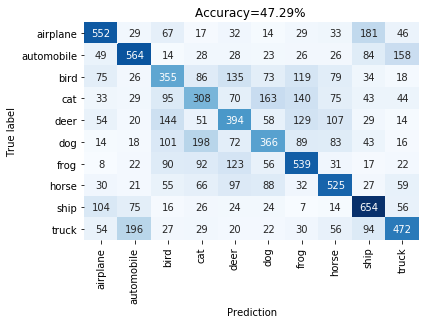

In [29]:
confusion_matrix(images_test, labels_test, W1_f4, W2_f4, b1_f4, b2_f4, title='')
plt.savefig('Figures/'+str(figure)+'_Confusion_Fig4.png', bbox_inches="tight"); figure+=1

### Coarse random search to set $\lambda$

First define a function for plotting the costs and accuracies for a list of $\lambda$ with a parametrization and data given.

In [30]:
def grid_search(list_lambdas, n_randomizations, hidden_dimension, X, Y, y, GDparams, X_val=None,
                Y_val=None, y_val=None, plot=True, log_scale=True):
    
    # Create a dictionary to store the performance metrics (mean/std by lambda)
    metrics_lambdas = {'lambdas':[], 'loss_train_mean':[], 'acc_train_mean':[], 'loss_train_std':[],
                          'acc_train_std':[]}
    if X_val is not None:
        metrics_lambdas['loss_val_mean'] = []
        metrics_lambdas['acc_val_mean'] = []
        metrics_lambdas['loss_val_std'] = []
        metrics_lambdas['acc_val_std'] = []

    # Iterate the lambda values
    for lambda_ in list_lambdas:
        
        # Create a dictionary to store the performance metrics of this particular lambda by randomizations
        metrics_init = {'loss_train':[], 'acc_train':[]}
        if X_val is not None:
            metrics_init['loss_val'] = []
            metrics_init['acc_val'] = []
        
        # Iterate random initalization seeds
        for seed in range(n_randomizations):
            
            # Initialize the weight randomly and train the network
            W1, b1, W2, b2 = initialize_weights(X.shape[0], hidden_dimension, Y.shape[0], seed=seed*100)
            W1, b1, W2, b2, metrics = MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2, X_val=X_val, 
                                                  Y_val=Y_val, y_val=y_val, lambda_=lambda_)

            # Save the performance metrics of the lambda for this random initalization
            metrics_init['loss_train'].append(metrics['loss_train'][-1])
            metrics_init['acc_train'].append(metrics['acc_train'][-1])
            if X_val is not None:
                metrics_init['loss_val'].append(metrics['loss_val'][-1])
                metrics_init['acc_val'].append(metrics['acc_val'][-1])
            
        # Save the performance metrics of the lambda (mean/std)
        metrics_lambdas['lambdas'].append(lambda_)
        metrics_lambdas['loss_train_mean'].append(np.mean(metrics_init['loss_train']))
        metrics_lambdas['acc_train_mean'].append(np.mean(metrics_init['acc_train']))
        metrics_lambdas['loss_train_std'].append(np.std(metrics_init['loss_train']))
        metrics_lambdas['acc_train_std'].append(np.std(metrics_init['acc_train']))
        if X_val is not None:
            metrics_lambdas['loss_val_mean'].append(np.mean(metrics_init['loss_val']))
            metrics_lambdas['acc_val_mean'].append(np.mean(metrics_init['acc_val']))
            metrics_lambdas['loss_val_std'].append(np.std(metrics_init['loss_val']))
            metrics_lambdas['acc_val_std'].append(np.std(metrics_init['acc_val']))
    
    if plot:
        _, axes = plt.subplots(1, 2, figsize=(15,5))
        title = 'for n_batch='+str(GDparams['n_batch'])+', cycles='+str(GDparams['cycles'])+ \
                ', eta_min='+str(GDparams['eta_min'])+', eta_max='+str(GDparams['eta_max'])+ \
                ', step_size='+str(GDparams['step_size'])+', '+str(n_randomizations)+' inits'
        plt.suptitle('Learning curves '+title)

        # Iterate the performance metrics
        for metric, ax in zip(['loss', 'acc'], axes.flatten()):

            # Find the optimal metric value and the corresponding lambda for training set
            optimal_lambda_train = np.argmin(metrics_lambdas[metric+'_train_mean']) if metric=='loss' \
                                   else np.argmax(metrics_lambdas[metric+'_train_mean'])
            optimal_train = np.round(metrics_lambdas[metric+'_train_mean'][optimal_lambda_train], 4)
            
            # Plot the learning curve of training set
            x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
            y = metrics_lambdas[metric+'_train_mean']
            yerr = [std*3 for std in metrics_lambdas[metric+'_train_std']]
            label = 'Train: '+str(optimal_train)+ ' at $\lambda$ '+ \
                    str(metrics_lambdas['lambdas'][optimal_lambda_train])
            ax.errorbar(x, y, yerr, label=label, fmt='o')
            
            # If validation set...
            if len(metrics_lambdas)>3:

                # Find the optimal metric value and the corresponding lambda for training set
                optimal_lambda_val = np.argmin(metrics_lambdas[metric+'_val_mean']) if metric=='loss' \
                                     else np.argmax(metrics_lambdas[metric+'_val_mean'])
                optimal_val = np.round(metrics_lambdas[metric+'_val_mean'][optimal_lambda_val], 4)
            
                # Plot the learning curve of validation set
                x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
                y = metrics_lambdas[metric+'_val_mean']
                yerr = [std*3 for std in metrics_lambdas[metric+'_val_std']]
                label = 'Validation: '+str(optimal_val)+ ' at $\lambda$ '+ \
                        str(metrics_lambdas['lambdas'][optimal_lambda_val])
                ax.errorbar(x, y, yerr, label=label, fmt='o')

            # Add axis, legend and grid
            ax.set_xlabel("Log Lambdas" if log_scale else "Lambdas")
            ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
            ax.legend()
            ax.grid(True)

    return metrics_lambdas

Use all the available training data for training (all five batches minus a small subset of 5000 training images for a validation set). Then, it is necessary to reload the data batches and do the normalization since we have to normalize the validation and test set respect to the new training data of size 45000 images.

In [31]:
images_1, labels_one_hot_1, labels_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
images_2, labels_one_hot_2, labels_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
images_3, labels_one_hot_3, labels_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
images_4, labels_one_hot_4, labels_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
images_5, labels_one_hot_5, labels_5 = LoadBatch('cifar-10-batches-py/data_batch_5')
images_test, labels_one_hot_test, labels_test = LoadBatch('cifar-10-batches-py/test_batch')

# Stack all the data batches
images = np.hstack((images_1, images_2, images_3, images_4, images_5))
labels_one_hot = np.hstack((labels_one_hot_1, labels_one_hot_2, labels_one_hot_3, labels_one_hot_4,
                            labels_one_hot_5))
labels = labels_1+labels_2+labels_3+labels_4+labels_5

# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(images.shape[1]), 5000, replace=False)
images_val = images[:,indexes_validation]
labels_one_hot_val = labels_one_hot[:,indexes_validation]
labels_val = [labels[i] for i in indexes_validation]

# Subset the training set
images_train = np.delete(images, indexes_validation, 1)
labels_one_hot_train = np.delete(labels_one_hot, indexes_validation, 1)
labels_train = [labels[i] for i in range(images.shape[1]) if i not in indexes_validation]

# Normalize the data
std_by_pixel_train = images_train.std(axis=1).reshape(images_train.shape[0], 1)
mean_by_pixel_train = images_train.mean(axis=1).reshape(images_train.shape[0], 1)
images_train = (images_train-mean_by_pixel_train)/std_by_pixel_train
images_val = (images_val-mean_by_pixel_train)/std_by_pixel_train
images_test = (images_test-mean_by_pixel_train)/std_by_pixel_train

Define the list of lambdas to try with uniform sampling.

In [32]:
np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_lambdas_coarse = list(10**l)
list_lambdas_coarse.sort()
list_lambdas_coarse

[0.000341795291206101,
 0.0004950159553733192,
 0.0005627932047415164,
 0.0015119336467640998,
 0.0015676677195506057,
 0.002576638574613588,
 0.0038333321561566606,
 0.007257005721594274,
 0.03690557729213758,
 0.07155682161754859]

Let's do the coarse search with th hyperparametrization: 

- 45.000 images for train and 5.000 for validation
- eta_min=1e-5 and eta_max=1e-1
- cycles = 2
- n_batch = 100
- step_size = 2 · epochs = 2 · # images / n_batch = 2 · 45.000 / 100 = 900

*Note*: If step_size = 2 · epochs, then 2 cycles is equivalent to 8 epoch = 2 cycles · 2 · 2 epochs

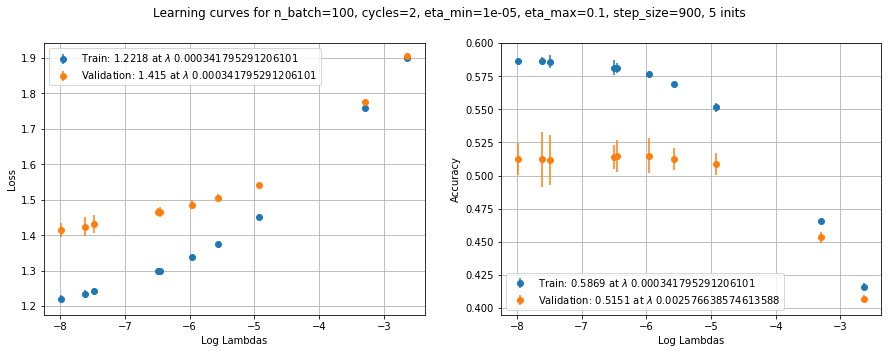

In [33]:
# Define the network parameters
GDparams_search = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2}
GDparams_search['step_size'] = int(2*images_train.shape[1]/GDparams_search['n_batch'])

# Run the search for lambda
metrics_by_lambdas_coarse = \
    grid_search(list_lambdas_coarse, n_randomizations=5, hidden_dimension=50, X=images_train, 
                Y=labels_one_hot_train, y=labels_train, GDparams=GDparams_search, X_val=images_val,
                Y_val=labels_one_hot_val, y_val=labels_val, plot=True, log_scale=True)
plt.savefig('Figures/'+str(figure)+'_Curves_Coarse.png', bbox_inches="tight"); figure+=1

### Fine random search to set lambda

Let's repeat the random search but with a search adjusted to a narrower range of lambdas.

In [34]:
list_lambdas_fine = np.arange(0, 0.008, 0.001)
list_lambdas_fine

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])

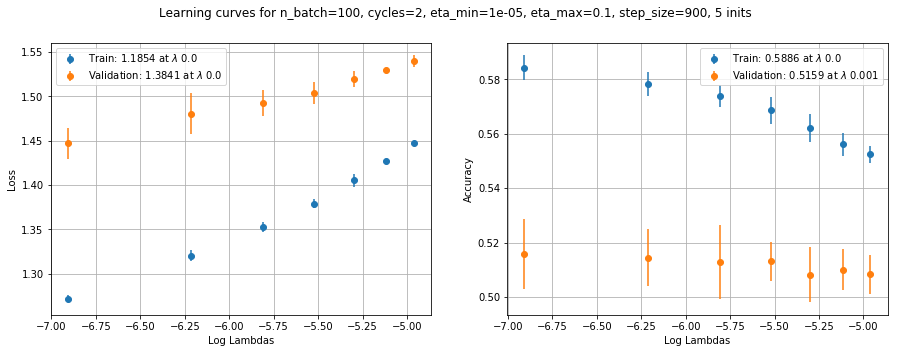

In [35]:
metrics_by_lambdas_fine = \
    grid_search(list_lambdas_fine, n_randomizations=5, hidden_dimension=50, X=images_train, 
                Y=labels_one_hot_train, y=labels_train, GDparams=GDparams_search, X_val=images_val,
                Y_val=labels_one_hot_val, y_val=labels_val, plot=True, log_scale=True)
plt.savefig('Figures/'+str(figure)+'_Curves_Fine.png', bbox_inches="tight"); figure+=1

### Best regularization $\lambda$ found in test

Now I will use the best $\lambda$ found and then train the network using almost all of the training data for more cycles and larger step size. Let's plot the training and validation loss plots and then see the learnt network's performance on the test data.

*Note*: It is equivalent to 48 epochs = 4 cycles · 2 · 800 / (45.000/450)

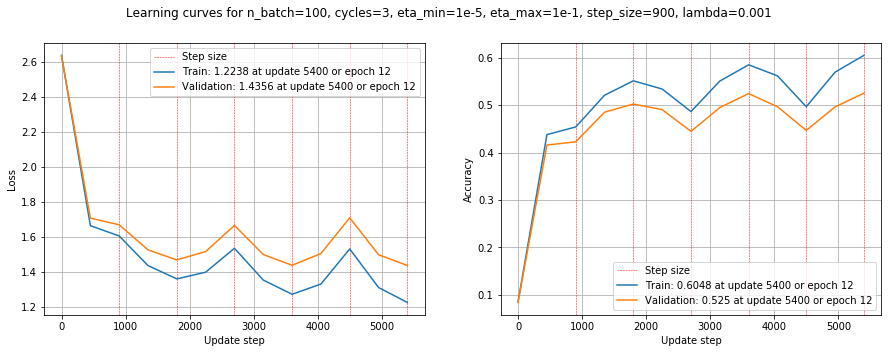

In [36]:
# Define the network parameters
lambda_best = 0.001

# Define the network parameters
GDparams_search['cycles'] = 3

# Train the network
W1_best, b1_best, W2_best, b2_best, metrics_best = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_search, W1, W2, b1, b2, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best)

# Plot the learning curve
title_best = 'for n_batch=100, cycles=3, eta_min=1e-5, eta_max=1e-1, step_size=900, lambda=0.001'
plot_learning_curve(metrics_best, title=title_best, step_size=GDparams_search['step_size'],
                    cycles=GDparams_search['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Best.png', bbox_inches="tight"); figure+=1

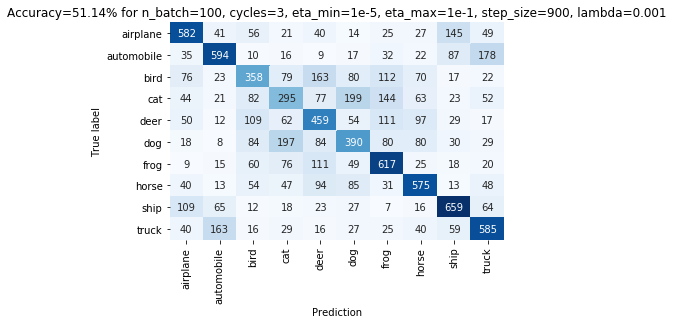

In [37]:
confusion_matrix(images_test, labels_test, W1_best, W2_best, b1_best, b2_best, title_best)
plt.savefig('Figures/'+str(figure)+'_Confusion_Best.png', bbox_inches="tight"); figure+=1

## Exercise 5: Optional for bonus points

### 5.1. Optimize the performance of the network

We will compare the results of next tricks or modifications with the best parametrization (best $\lambda$ found).

In [38]:
# Define the network parameters
lambda_best = 0.001
GDparams_search = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2}
GDparams_search['step_size'] = int(2*images_train.shape[1]/GDparams_search['n_batch'])

#### 5.1.a

Do a more exhaustive random search to find good values for the amount of regularization, the length of the cycles, number of cycles etc...

- Firstly, with the optimal $\lambda$ found in exercise 4 I will extend the number of cycles and see where is the optimal epoch for validation set by plotting the learning curves.

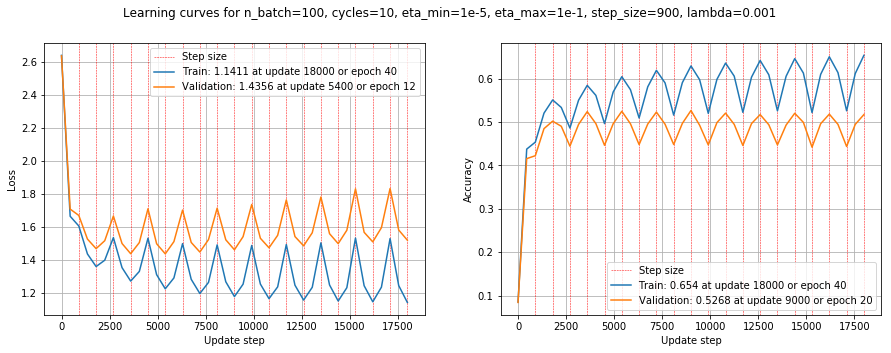

In [39]:
# Change the network parameters
GDparams_long = GDparams_search.copy()
GDparams_long['cycles'] = 10

# Train the network
W1_long, b1_long, W2_long, b2_long, metrics_long = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_long, W1, W2, b1, b2,
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best)

# Plot the learning curve
title_long = 'for n_batch=100, cycles=10, eta_min=1e-5, eta_max=1e-1, step_size=900, lambda=0.001'
plot_learning_curve(metrics_long, title=title_long,  step_size=GDparams_long['step_size'],
                    cycles=GDparams_long['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Long.png', bbox_inches="tight"); figure+=1

- Secondly, with the same parametrization than before I will increase the step size to 1350 (add 1 more epoch by step size), since in the previous learning curves we can see how the loss/accuracy is lower/higher at the end and beginning of cycles (near minimum learning rate).

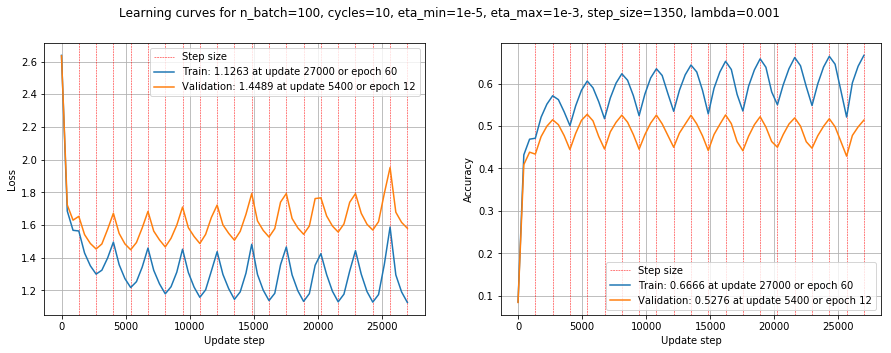

In [40]:
# Change the network parameters
GDparams_long2 = GDparams_search.copy()
GDparams_long2['cycles'] = 10
GDparams_long2['step_size'] = 1350

# Train the network
W1_long2, b1_long2, W2_long2, b2_long2, metrics_long2 = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_long2, W1, W2, b1, b2,
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best)

# Plot the learning curve
title_long2 = 'for n_batch=100, cycles=10, eta_min=1e-5, eta_max=1e-3, step_size=1350, lambda=0.001'
plot_learning_curve(metrics_long2, title=title_long2,  step_size=GDparams_long2['step_size'],
                    cycles=GDparams_long2['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Long2.png', bbox_inches="tight"); figure+=1

#### 5.1.b

Explore whether having more hidden nodes improves the final classification rate. One would expect that with more hidden nodes then the amount of regularization would have to increase.

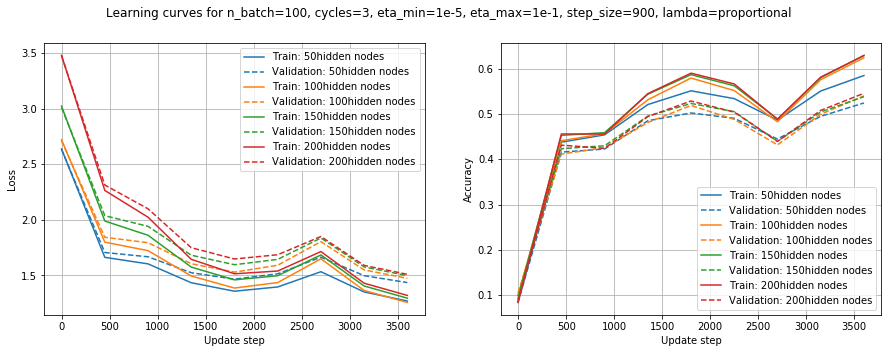

In [41]:
title_b = 'for n_batch=100, cycles=3, eta_min=1e-5, eta_max=1e-1, step_size=900, lambda=proportional'
_, axes = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Learning curves '+title_b)

input_dimension = images_train.shape[0]
output_dimension = labels_one_hot_train.shape[0]

# Iterate the hidden nodes to try
cmap = plt.get_cmap('tab10')
list_hidden_nodes = [50, 100, 150, 200]
for i, hidden_dimension in enumerate(list_hidden_nodes):
    
    # Initialize the weights (different architecture)
    W1_, b1_, W2_, b2_ = initialize_weights(input_dimension, hidden_dimension, output_dimension)
    
    # Set a proportional lambda to the initial 50 hidden nodes
    lambda_best_ = lambda_best*hidden_dimension/50
    
    # Train the network
    W1_, b1_, W2_, b2_, metrics_ = \
        MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_search, W1_, W2_, b1_, b2_,
                    X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best_)
    
    # Plot the loss learning curve of training and validation set
    label_0 = "Train: "+str(hidden_dimension)+"hidden nodes"
    label_1 = "Validation: "+str(hidden_dimension)+"hidden nodes"
    axes[0].plot(metrics_['updates'], metrics_['loss_train'], label=label_0, c=cmap(i))
    axes[0].plot(metrics_['updates'], metrics_['loss_val'], label=label_1, linestyle="--", c=cmap(i))
        
    # Plot the accuracy learning curve of training and validation set
    axes[1].plot(metrics_['updates'], metrics_['acc_train'], label=label_0, c=cmap(i))
    axes[1].plot(metrics_['updates'], metrics_['acc_val'], label=label_1, linestyle="--",  c=cmap(i))

# Add axis, legend and grid
axes[0].set_xlabel("Update step")
axes[1].set_xlabel("Update step")
axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Accuracy')
axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)

plt.savefig('Figures/'+str(figure)+'_Hidden_Nodes.png', bbox_inches="tight"); figure+=1

#### 5.1.c

At the end of each cycle of training we should be in the vicinity of a local minimum. Research in this area seems to indicate that with the cyclical learning rate method the local minima found at the end of each cycle are different and thus we can build an ensemble of classifiers by saving the network parameter values at the end of each cycle. Using this ensemble to classify may result in better classification than one model.

In [42]:
# Change the network parameters
GDparams_ensemble = GDparams_search.copy()
GDparams_ensemble['cycles'] = 10

# Train the network
W1_best, b1_best, W2_best, b2_best, metrics_best, weights_by_cycles = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_ensemble, W1, W2, b1, b2, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best,
                return_weights_by_cycles=True)

Define a function to ensemble the predictions of each cycle weights given some images.

In [43]:
def ensemble(weights_by_cycles, X):
    n = X.shape[1]
    votes = np.zeros(shape=(len(weights_by_cycles),n))

    # Iterate the ensemble weihts by cycles
    for cycle in weights_by_cycles:
        (W1, b1, W2, b2) = weights_by_cycles[cycle]
    
        # Compute the predictions and the votes
        P, H = EvaluateClassifier(X, W1, b1, W2, b2)
        votes[cycle,:] = np.argmax(P, 0)
   
    # Compute and return the majority vote
    majority_votes = stats.mode(votes).mode
    
    return majority_votes

Evaluate the accuracy in validation and test sets after ensembling.

In [44]:
majority_votes_val = ensemble(weights_by_cycles, images_val)
print('The accuracy in validation set is '+str(np.mean(labels_val==majority_votes_val)*100)+'%')

majority_votes_test = ensemble(weights_by_cycles, images_test)
print('The accuracy in test set is '+str(np.mean(labels_test==majority_votes_test)*100)+'%')

The accuracy in validation set is 52.54%
The accuracy in test set is 51.190000000000005%


#### 5.1.d

Apply dropout to the training.

*Note:* Each training sample in the mini-batch has its own random dropout mask which means that the same activations (hidden nodes) in the hidden layer will be deactivated (turned to 0) for that sample. For selecting which nodes deactivate I will use random uniform values between 0 and 1 and if the value is above the given dropout probability of keeping the value then the hidden node is deactivated.

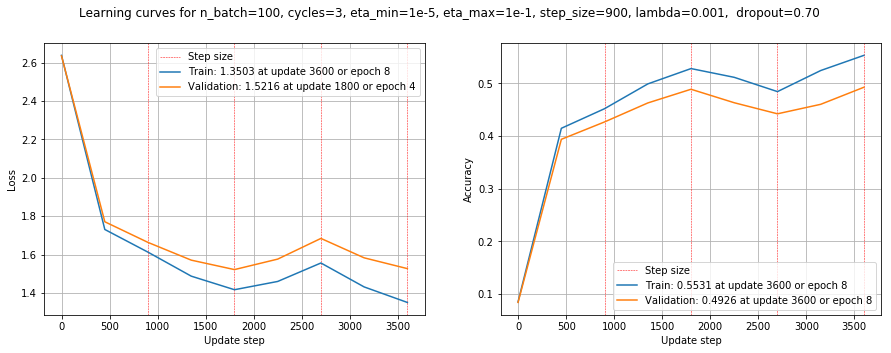

In [45]:
# Train the network
W1_dropout, b1_dropout, W2_dropout, b2_dropout, metrics_dropout = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_search, W1, W2, b1, b2, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best,
                dropout=0.70)

# Plot the learning curve
title_dropout = 'for n_batch=100, cycles=3, eta_min=1e-5, eta_max=1e-1, step_size=900, lambda=0.001, '+ \
                ' dropout=0.70'
plot_learning_curve(metrics_dropout, title=title_dropout,  step_size=GDparams_search['step_size'],
                    cycles=GDparams_search['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Dropout.png', bbox_inches="tight"); figure+=1

### 5.2. Read reference [Smith, 2015] and set eta min and eta max to the guidelines in the paper

From the paper, the guidelines or technique to choose the learning rate range is:

- *It is a \LR range test"; run your model for several epochs while letting the learning rate increase linearly between low and high LR values.*

- *The triangular learning rate policy provides a simple mechanism to do this. For example, in Caffe, set base learning rate to the minimum value and set max learning rate to the maximum value. Set both the step size and max iter to the same number of iterations. In this case, the learning rate will increase linearly from the minimum value to the maximum value during this short run.*

- *Next, plot the accuracy versus learning rate. Note the learning rate value when the accuracy starts to increase and when the accuracy slows, becomes ragged, or starts to fall. These two learning rates are good choices for bounds; that is, set base learning rate to the first value and set maximum learning rate to the latter value.*

Then, for training the network increasing linearly the learning rate during several epochs, between the minimum and maximum value, I will increase the step size to 4500 (10 epochs), and then I will use the created option *max_updates* in the function *MiniBatchGD* to set a limit of updates according to the same step size. Also, I will define a wider range for the learning rate: 0 for eta_min and 0.1 for eta_max.

In [46]:
# Change the network parameters
GDparams_smith = GDparams_search.copy()
GDparams_smith['step_size'] = 4500
GDparams_smith['eta_min'] = 0
GDparams_smith['eta_max'] = 0.1

# Train the network
W1_smith, b1_smith, W2_smith, b2_smith, metrics_smith, etas_smith, update_step_smith = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_smith, W1, W2, b1, b2, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best,
                max_updates=GDparams_smith['step_size'], return_etas=True)

After training for 1 step size updates, I will plot the accuracy versus the learning rate of each update. I will note the learning rate value when the accuracy starts to increase and when the accuracy slows, becomes ragged, or starts to fall. These two learning rates are good choices for bounds.

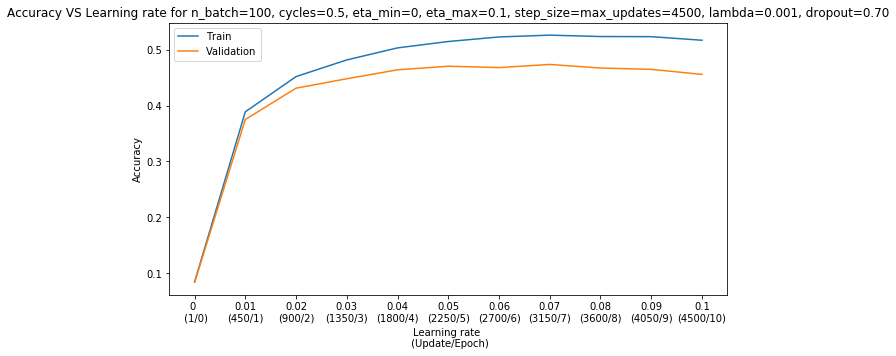

In [47]:
plt.figure(figsize=(10,5))
x_etas = [0]
x_labels = ["0 \n (1/0)"]
for epoch, update in enumerate(metrics_smith['updates']):
    if update!=-1:
        x_etas.append(etas_smith[update-1])
        x_labels.append(str(np.round(etas_smith[update-1], 4))+"\n("+str(update)+"/"+str(epoch)+')')
plt.plot(x_etas, metrics_smith['acc_train'], label="Train")
plt.plot(x_etas, metrics_smith['acc_val'], label="Validation")
plt.xticks(x_etas, labels=x_labels)
plt.xlabel("Learning rate \n (Update/Epoch)")
plt.ylabel("Accuracy")
plt.legend()
title_smith = 'for n_batch=100, cycles=0.5, eta_min=0, eta_max=0.1, step_size=max_updates=4500, lambda='+\
              str(lambda_best)+', dropout=0.70'
plt.title("Accuracy VS Learning rate "+title_smith)
plt.savefig('Figures/'+str(figure)+'_CLR_Smith.png', bbox_inches="tight"); figure+=1

Let's see the results of the optimal previous parametrization with the new learning rate boundaries (from 0 to 0.05).

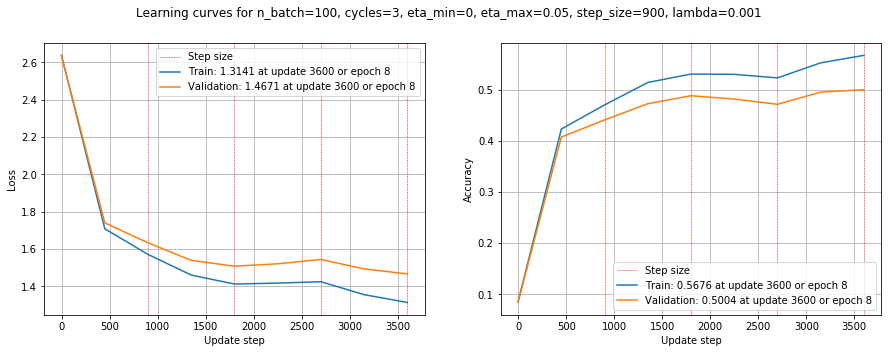

In [48]:
# Change the network parameters
GDparams_smith2 = GDparams_search.copy()
GDparams_smith2['eta_min'] = 0
GDparams_smith2['eta_max'] = 0.05

# Train the network
W1_smith2, b1_smith2, W2_smith2, b2_smith2, metrics_smith2 = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams_smith2, W1, W2, b1, b2, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, lambda_=lambda_best)

# Plot the learning curve
title_smith2 = 'for n_batch=100, cycles=3, eta_min=0, eta_max=0.05, step_size=900, lambda=0.001'
plot_learning_curve(metrics_smith2, title=title_smith2, step_size=GDparams_smith2['step_size'],
                    cycles=GDparams_smith2['cycles'])
plt.savefig('Figures/'+str(figure)+'_Curves_Smith.png', bbox_inches="tight"); figure+=1